### Advanced Machine Learning

# Final Assignment  - Detect True vs False Stories (lie detection)

Assignment Start: 11/07/21 00:00<br>
Assignment Due: 18/07/21 23:59 (moodle will be closed for submissions that time)

Jonathan Schler


In [6]:
id="323637736"
name="Alexander Kruglyak"

## Introduction
You are provided with a labeled corpus of narratives in Hebrew. The corpus is provided as a csv file. Each row represents a narrative. It has 5 fields: id, author_gender, author_birth_year, narrative and label. The label for each narrative indicates whether this is a true or false story (i.e. the author lied when he told the story) (label "1" for True, and "0" for false). 

You are requested to build a model to predict whether a new story in Hebrew is true or false (i.e a lie). You are provided with 2 files: 
- `train_dataset.csv` - which contains **labeled** examples, and 
- `test_dataset.csv` that contains **unlabled** examples that you'll have to classify and submit the results. The narrtives in this file will have the same fields except of the label field.

(you'll be graded based on the quality of the labels assigned to the `test_dataset.csv`).





## What is expected from you
1. Build a classifier (including all pre-processing steps - as you think may fit (feature engineering, pre-processing, scaling etc) ) that will classify an unlabled document (including reasonable documentation for the steps you chose to do)
2. Report on how you chose to evaluate your algorithm and the scores of that evaluation
3. Apply the model on the unlabeled data set (`test_dataset.csv`), and return the results in the format described below
4. At the end, you are requested to submit 2 files: (a) this notebook, and (b) the output csv file. Submission will be done via moodle. The output csv is the file, that contains the prediction for the `test_dataset.csv`. The naming of the file should be `<your_id_number>.csv` (where `<your_id_number>` will be replaced with you actual ID number). The file will contain for each doc a label `1` (for true narratives) or `0` (for false narratives) (such that each row contains only one label, corresponding to the document in the given row in the `test_dataset.csv` document). You can see a sample output file under the name `123456789.csv` in the moodle.

## Grading Guidelines
1. Overall approach and workable solution (70 pts)
2. Average f1 score of higher than 0.50 (10 pts)
3. Average f1 score of higher than 0.58 (additional 5 pts)
4. Competitive element: 15 Highest average f1 score - will get additional 15 pts, top score the extra 15 points, second highest - extra 14 points etc - in case of similar scores it will be divided proportionaly.

## Other Guidelines
1. Work in indivudual, collaboration is not allowed. 
2. You are allowed to use all the toolsets we learned / mentioned in class, in addition to any other avialble toolsets for text processing or Hebrew data as you think is appropriate.


## Good Luck!

In [7]:
%pip install python-bidi

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, RidgeClassifierCV, SGDClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import normalize


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from bidi import algorithm as bidialg


Note: you may need to restart the kernel to use updated packages.


In [8]:
def drop_columns(df, columns):
    return df.copy().drop(columns, axis=1)

def get_label_and_drop(_df):
    df = _df.copy()
    label = df['label']
    df = drop_columns(df,['label'])
    return df, label

In [9]:
COLS_TO_DROP = ["Unnamed: 0"]

df_train = drop_columns(pd.read_csv("train_dataset.csv"), COLS_TO_DROP)
df_test = drop_columns(pd.read_csv("test_dataset.csv"), COLS_TO_DROP)

In [10]:
df_train.head()

,author_gender,author_birth_year,narrative,label
0,זכר,1995,"שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה ...",1
1,זכר,1992,בשנת 2018 קיבלתי החלטה שאני מתחיל ללמוד לתואר ...,1
2,זכר,1992,לפני מספר שנים אני ובת הזוג שלי טסנו ללונדון ז...,1
3,נקבה,1991,"האישה שבקושי הכרתי חייכה תמיד, העיניים שלה ברק...",1
4,נקבה,1992,בדרך חזרה מהטיול שנתי בכיתה ח' התקשרתי לאבא של...,1


In [11]:
# steps
# autrhor_gender -> category to numeric/hot encoding
# feature engineering: lenght of text
# use of specific dates: like year 2020, or on Aug. 13

In [12]:
def show_data_basic_information(df):
    print("Info\n")
    print(df.info())
    print("\n" + "*" * 10 + "\n")
    
    print("Shape\n")
    print(df.shape) 
    print("\n" + "*" * 10 + "\n")
    
    print("Amount of is null data\n")
    print(df.isnull().sum().max())
    print("\n" + "*" * 10 + "\n")
    
    print("Describe\n")
    display(df.describe())
    print("\n" + "*" * 10 + "\n")

In [13]:
show_data_basic_information(df_train)

Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   author_gender      408 non-null    object
 1   author_birth_year  408 non-null    int64 
 2   narrative          408 non-null    object
 3   label              408 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 12.9+ KB
None

**********

Shape

(408, 4)

**********

Amount of is null data

0

**********

Describe



,author_birth_year,label
count,408.000000,408.000000
mean,1993.573529,0.500000
std,3.370560,0.500614
min,1980.000000,0.000000
25%,1992.750000,0.000000
50%,1994.000000,0.500000
75%,1995.000000,1.000000
max,2002.000000,1.000000



**********



In [14]:
def get_dummies(_df,columns_to_dummy):
    df = _df.copy()
    df = pd.get_dummies(df,columns=columns_to_dummy)
    return df

def translate_author_gender(_df):
    df = _df.copy()
    _df["author_gender"].replace(to_replace="זכר", value='male', inplace=True)
    _df["author_gender"].replace(to_replace="נקבה", value="female", inplace=True)
    return _df


def get_dummies(_df,columns_to_dummy):
    df = _df.copy()
    df = pd.get_dummies(df,columns=columns_to_dummy)
    return df

def translate_author_gender(_df):
    df = _df.copy()
    print(df.head())
    _df["author_gender"].replace(to_replace="זכר", value='male', inplace=True)
    _df["author_gender"].replace(to_replace="נקבה", value="female", inplace=True)
    return _df

def prepare_data(_df):
    df = _df.copy()
    return get_dummies(translate_author_gender(df), ["author_gender"])


# df_train = get_dummies(translate_author_gender(df_train), ["author_gender"])
df_train = prepare_data(df_train)
df_test = prepare_data(df_test)

  author_gender  author_birth_year  \
0           זכר               1995   
1           זכר               1992   
2           זכר               1992   
3          נקבה               1991   
4          נקבה               1992   

                                           narrative  label  
0  שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה ...      1  
1  בשנת 2018 קיבלתי החלטה שאני מתחיל ללמוד לתואר ...      1  
2  לפני מספר שנים אני ובת הזוג שלי טסנו ללונדון ז...      1  
3  האישה שבקושי הכרתי חייכה תמיד, העיניים שלה ברק...      1  
4  בדרך חזרה מהטיול שנתי בכיתה ח' התקשרתי לאבא של...      1  
  author_gender  author_birth_year  \
0           זכר               2002   
1          נקבה               1995   
2           זכר               1995   
3           זכר               1991   
4           זכר               1995   

                                           narrative  
0  זה התחיל בשעת השקיעה.הגענו לחוף מדרום לעין גדי...  
1  כזוג מאורס טרי סגרנו תאריך, אולם אירועים, ספקי...  
2  הג

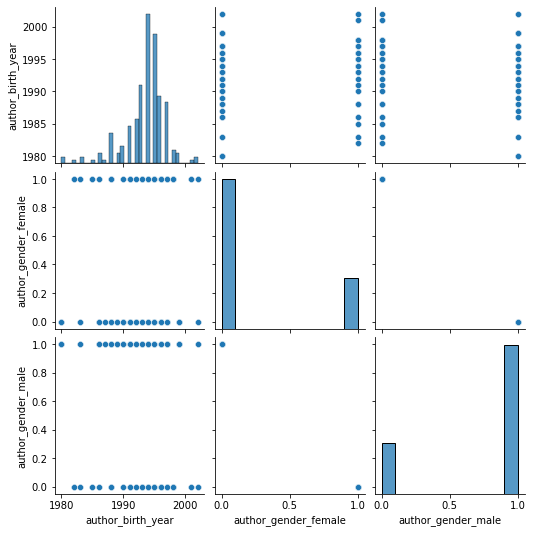

In [15]:
sns.pairplot(df_train[['author_birth_year','author_gender_female','author_gender_male']])

In [16]:
# X, Y = get_label_and_drop(df)
# X

In [17]:
print(pd.Series(' '.join(df_train['narrative']).lower().split()).value_counts()[:20])

את       2642
לא       1866
של       1308
על       1202
היה      1126
עם       1086
לי       1017
אני       927
כל        925
שלי       903
זה        797
לאחר      638
מאוד      539
אבל       528
הוא       513
גם        496
מה        495
שאני      478
כי        465
הייתה     423
dtype: int64


In [18]:
# vect = CountVectorizer(min_df=1)
# X_train = vect.fit_transform(text_train)
# print(X_train.shape, Y_train.shape)

In [19]:
# #Vocabulary
# feature_names = vect.get_feature_names()
# print(feature_names[:10])
# print(feature_names[300:310])
# print(feature_names[500:510])
# print(feature_names[800:810])
# print(feature_names[1000:1010])
# print(feature_names[1500:1510])

In [20]:
# lr = LogisticRegression(n_jobs=-1).fit(text_train, Y_train)
# x_val = vect.transform(text_val)
# lr.score(x_val,Y_val)
# it seems like overfit

In [21]:
def train_and_predict(estimator,X_train,y_train,X_test):
    model = estimator.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return model,y_pred

In [22]:
# just to see that model is working
text_trainval = df_train['narrative'].tolist()
y_trainval = df_train['label']

text_train, text_val, y_train, y_val = train_test_split(
    text_trainval, y_trainval, stratify=y_trainval, random_state=0)


vect = CountVectorizer(min_df=4)
X_train = vect.fit_transform(text_train)
X_val = vect.transform(text_val)

lr = LogisticRegression().fit(X_train, y_train)
print(len(vect.get_feature_names()))

lr.score(X_val, y_val)

3373


0.46078431372549017

In [23]:
X = df_train['narrative'].tolist()
Y = df_train['label']

vect = CountVectorizer(min_df=4)
X_train = vect.fit_transform(X)

lr = LogisticRegression(n_jobs=-1).fit(X_train, Y)

In [24]:
regressors = [
    LogisticRegression(),
    LogisticRegressionCV(),
    PassiveAggressiveClassifier(),
    Perceptron(),
    RidgeClassifier(),
    RidgeClassifierCV(),
    SGDClassifier()
]

def add_score(scores_df, scores, regressorName, dataType):
    scores_df.loc[regressorName + '_' + dataType, 'f1'] = scores['test_f1'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'recall'] = scores['test_recall'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'roc_auc'] = scores['test_roc_auc'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'average_precision'] = scores['test_average_precision'].mean()

def get_cross_val_score(scores_df,estimator,X_train,y_train,prefix="",sampler=None):
        name = estimator.__class__.__name__
        pipe = estimator
        sampler_name = ""
        if sampler is not None:
            pipe = make_imb_pipeline(sampler(random_state=42), estimator)
            sampler_name = sampler.__name__
        print('*********' + name + ' ' + sampler_name + '*********')
        score = cross_validate(
            pipe,
            X_train, 
            y_train, 
            cv=10,
            scoring=('roc_auc', 'average_precision', 'f1', 'recall'),
            n_jobs = -1
        )
        add_score(scores_df, score, name,prefix)
        
        
scores_df = pd.DataFrame(dtype=float)
        
for regr in regressors:
#     get_cross_val_score(scores_df,regr, X_train, y_train,"numerical")
    get_cross_val_score(scores_df,regr, X_train, Y,"CountVectorizer_without_stop_words")

scores_df

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


,f1,recall,roc_auc,average_precision
LogisticRegression_CountVectorizer_without_stop_words,0.522817,0.529762,0.555738,0.581970
LogisticRegressionCV_CountVectorizer_without_stop_words,0.501239,0.495476,0.553357,0.588391
PassiveAggressiveClassifier_CountVectorizer_without_stop_words,0.518974,0.519762,0.557321,0.588768
Perceptron_CountVectorizer_without_stop_words,0.540853,0.563571,0.567696,0.595002
RidgeClassifier_CountVectorizer_without_stop_words,0.508694,0.505714,0.550548,0.581414
RidgeClassifierCV_CountVectorizer_without_stop_words,0.528617,0.535000,0.549357,0.579483
SGDClassifier_CountVectorizer_without_stop_words,0.523917,0.529048,0.576810,0.603378


In [25]:
# try with stop words

# https://github.com/gidim/HebrewStopWords
stop_words = [x.strip() for x in open('heb_stopwords.txt','r').read().split('\n')]

vect = CountVectorizer(min_df=4, stop_words=stop_words)
X_train = vect.fit_transform(X)


for regr in regressors:
#     get_cross_val_score(scores_df,regr, X_train, y_train,"numerical")
    get_cross_val_score(scores_df,regr, X_train, Y, "CountVectorizer_with_stop_words")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [26]:
print(len(vect.get_feature_names()))

display(scores_df.sort_values(by="f1"))

3932


,f1,recall,roc_auc,average_precision
LogisticRegressionCV_CountVectorizer_without_stop_words,0.501239,0.495476,0.553357,0.588391
RidgeClassifier_CountVectorizer_without_stop_words,0.508694,0.505714,0.550548,0.581414
Perceptron_CountVectorizer_with_stop_words,0.516007,0.513571,0.576607,0.597775
PassiveAggressiveClassifier_CountVectorizer_without_stop_words,0.518974,0.519762,0.557321,0.588768
LogisticRegression_CountVectorizer_without_stop_words,0.522817,0.529762,0.555738,0.581970
SGDClassifier_CountVectorizer_without_stop_words,0.523917,0.529048,0.576810,0.603378
RidgeClassifierCV_CountVectorizer_without_stop_words,0.528617,0.535000,0.549357,0.579483
RidgeClassifierCV_CountVectorizer_with_stop_words,0.538458,0.534762,0.581060,0.606632
Perceptron_CountVectorizer_without_stop_words,0.540853,0.563571,0.567696,0.595002
PassiveAggressiveClassifier_CountVectorizer_with_stop_words,0.543403,0.544286,0.571345,0.599766


In [27]:
df_train['narrative'] = df_train['narrative'].replace(b"<br />", b" ")

X = df_train['narrative'].tolist()
# Y = df_train['label']

tdif = TfidfVectorizer(stop_words=stop_words,min_df=4)
X_train = tdif.fit_transform(X)

for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, Y,"TfidfVectorizer")

display(scores_df.sort_values(by="f1"))

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


,f1,recall,roc_auc,average_precision
LogisticRegressionCV_CountVectorizer_without_stop_words,0.501239,0.495476,0.553357,0.588391
RidgeClassifier_CountVectorizer_without_stop_words,0.508694,0.505714,0.550548,0.581414
Perceptron_CountVectorizer_with_stop_words,0.516007,0.513571,0.576607,0.597775
PassiveAggressiveClassifier_CountVectorizer_without_stop_words,0.518974,0.519762,0.557321,0.588768
SGDClassifier_TfidfVectorizer,0.522389,0.525952,0.577393,0.605136
LogisticRegression_CountVectorizer_without_stop_words,0.522817,0.529762,0.555738,0.581970
SGDClassifier_CountVectorizer_without_stop_words,0.523917,0.529048,0.576810,0.603378
Perceptron_TfidfVectorizer,0.527512,0.524286,0.570857,0.602078
RidgeClassifierCV_CountVectorizer_without_stop_words,0.528617,0.535000,0.549357,0.579483
PassiveAggressiveClassifier_TfidfVectorizer,0.530079,0.540000,0.577345,0.600627


In [28]:
print(len(X))
print(len(tdif.get_feature_names()))


408
3932


In [29]:
# lets try to normalize data
vect = CountVectorizer(min_df=4, stop_words=stop_words)
X_train = vect.fit_transform(X)
X_train = normalize(X_train,norm="l1")

for regr in regressors:
#     get_cross_val_score(scores_df,regr, X_train, y_train,"numerical")
    get_cross_val_score(scores_df,regr, X_train, Y, "CountVectorizer_normalized")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [30]:
scores_df

,f1,recall,roc_auc,average_precision
LogisticRegression_CountVectorizer_without_stop_words,0.522817,0.529762,0.555738,0.581970
LogisticRegressionCV_CountVectorizer_without_stop_words,0.501239,0.495476,0.553357,0.588391
PassiveAggressiveClassifier_CountVectorizer_without_stop_words,0.518974,0.519762,0.557321,0.588768
Perceptron_CountVectorizer_without_stop_words,0.540853,0.563571,0.567696,0.595002
RidgeClassifier_CountVectorizer_without_stop_words,0.508694,0.505714,0.550548,0.581414
RidgeClassifierCV_CountVectorizer_without_stop_words,0.528617,0.535000,0.549357,0.579483
SGDClassifier_CountVectorizer_without_stop_words,0.523917,0.529048,0.576810,0.603378
LogisticRegression_CountVectorizer_with_stop_words,0.550365,0.554048,0.587250,0.612803
LogisticRegressionCV_CountVectorizer_with_stop_words,0.547674,0.544524,0.617250,0.625366
PassiveAggressiveClassifier_CountVectorizer_with_stop_words,0.543403,0.544286,0.571345,0.599766


In [31]:
X = df_train['narrative'].tolist()

tdif = TfidfVectorizer(stop_words=stop_words,min_df=4)
X_train = tdif.fit_transform(X)
X_train = normalize(X_train,norm="l1")

for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, Y,"TfidfVectorizer_normalized")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [32]:
display(scores_df.sort_values(by="f1"))

,f1,recall,roc_auc,average_precision
LogisticRegression_TfidfVectorizer_normalized,0.432473,0.528333,0.617155,0.633998
LogisticRegression_CountVectorizer_normalized,0.482378,0.556905,0.622655,0.636156
LogisticRegressionCV_CountVectorizer_without_stop_words,0.501239,0.495476,0.553357,0.588391
RidgeClassifier_CountVectorizer_without_stop_words,0.508694,0.505714,0.550548,0.581414
Perceptron_CountVectorizer_with_stop_words,0.516007,0.513571,0.576607,0.597775
PassiveAggressiveClassifier_CountVectorizer_without_stop_words,0.518974,0.519762,0.557321,0.588768
SGDClassifier_TfidfVectorizer,0.522389,0.525952,0.577393,0.605136
LogisticRegression_CountVectorizer_without_stop_words,0.522817,0.529762,0.555738,0.581970
SGDClassifier_CountVectorizer_without_stop_words,0.523917,0.529048,0.576810,0.603378
Perceptron_TfidfVectorizer,0.527512,0.524286,0.570857,0.602078


In [33]:
#ngrams
ngrm = CountVectorizer(min_df=4, stop_words=stop_words, ngram_range=(1, 3))
X_train = ngrm.fit_transform(X)

for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, Y,"CountVectorizer_ngram")

display(scores_df.sort_values(by="f1"))

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


,f1,recall,roc_auc,average_precision
LogisticRegression_TfidfVectorizer_normalized,0.432473,0.528333,0.617155,0.633998
LogisticRegression_CountVectorizer_normalized,0.482378,0.556905,0.622655,0.636156
LogisticRegressionCV_CountVectorizer_without_stop_words,0.501239,0.495476,0.553357,0.588391
RidgeClassifier_CountVectorizer_without_stop_words,0.508694,0.505714,0.550548,0.581414
Perceptron_CountVectorizer_with_stop_words,0.516007,0.513571,0.576607,0.597775
PassiveAggressiveClassifier_CountVectorizer_without_stop_words,0.518974,0.519762,0.557321,0.588768
SGDClassifier_TfidfVectorizer,0.522389,0.525952,0.577393,0.605136
LogisticRegression_CountVectorizer_without_stop_words,0.522817,0.529762,0.555738,0.581970
SGDClassifier_CountVectorizer_without_stop_words,0.523917,0.529048,0.576810,0.603378
Perceptron_TfidfVectorizer,0.527512,0.524286,0.570857,0.602078


In [34]:
#ngrams + normalize
ngrm = CountVectorizer(min_df=4, stop_words=stop_words, ngram_range=(1, 3))
X_train = ngrm.fit_transform(X)
X_train = normalize(X_train,norm="l1")

for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, Y,"CountVectorizer_ngram_normalize")



*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [35]:
display(scores_df.sort_values(by="f1",ascending=False))

,f1,recall,roc_auc,average_precision
SGDClassifier_CountVectorizer_normalized,0.639061,0.730952,0.624643,0.639811
SGDClassifier_TfidfVectorizer_normalized,0.635530,0.776667,0.620310,0.639329
SGDClassifier_CountVectorizer_ngram_normalize,0.621375,0.726905,0.621298,0.634211
Perceptron_CountVectorizer_ngram_normalize,0.598321,0.656905,0.592726,0.620293
RidgeClassifierCV_CountVectorizer_normalized,0.592892,0.602619,0.620702,0.638202
RidgeClassifierCV_CountVectorizer_ngram_normalize,0.591275,0.597619,0.619274,0.633791
RidgeClassifier_CountVectorizer_ngram_normalize,0.581972,0.590714,0.619369,0.631972
LogisticRegressionCV_CountVectorizer_ngram_normalize,0.576879,0.583333,0.602571,0.621172
LogisticRegressionCV_CountVectorizer_normalized,0.571452,0.573333,0.596798,0.616405
RidgeClassifier_CountVectorizer_normalized,0.570913,0.576190,0.622179,0.637638


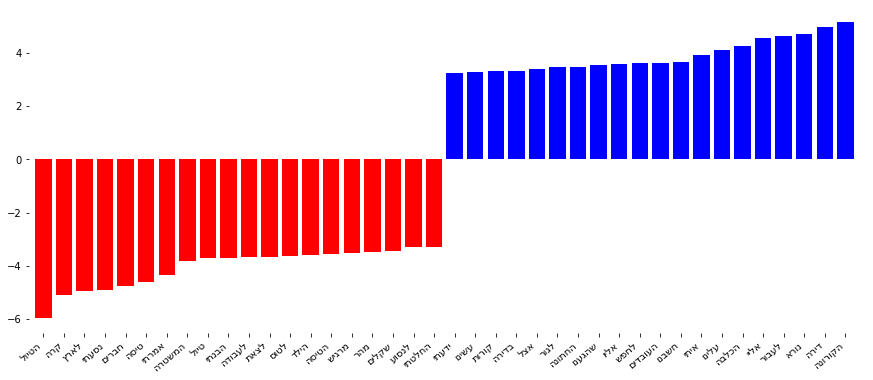

In [36]:
# IMPORTANT WORDS
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    heb_feature_names =[bidialg.get_display(feature) for feature in feature_names[important]]
    ax.set_xticklabels(heb_feature_names, rotation=rotation, ha="right")
#     ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)

    
vect = CountVectorizer(min_df=4, stop_words=stop_words)
X_train = vect.fit_transform(X)
X_train = normalize(X_train,norm="l1")

sgdc = SGDClassifier()
sgdc.fit(X_train, Y)
    
plt.figure(figsize=(15, 6))
plot_important_features(sgdc.coef_.ravel(), np.array(vect.get_feature_names()), top_n=20, rotation=40)
ax = plt.gca()
plt.show()